In [1]:
import fastai 
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [2]:
torch.cuda.set_device(1)

In [3]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

## Crappified data

In [4]:
from fastai.vision import *
from PIL import Image, ImageDraw, ImageFont

#Turning nice images into crappy images

class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        targ_sz = resize_to(img, 96, use_min=True)
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)

In [5]:
il = ImageList.from_folder(path_hr)
parallel(crappifier(path_lr, path_hr), il.items)

In [6]:
bs,size=32, 128
# bs,size = 24,160
#bs,size = 8,256
arch = models.resnet34

## Pre-train generator

In [10]:
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1,seed=42)

In [11]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

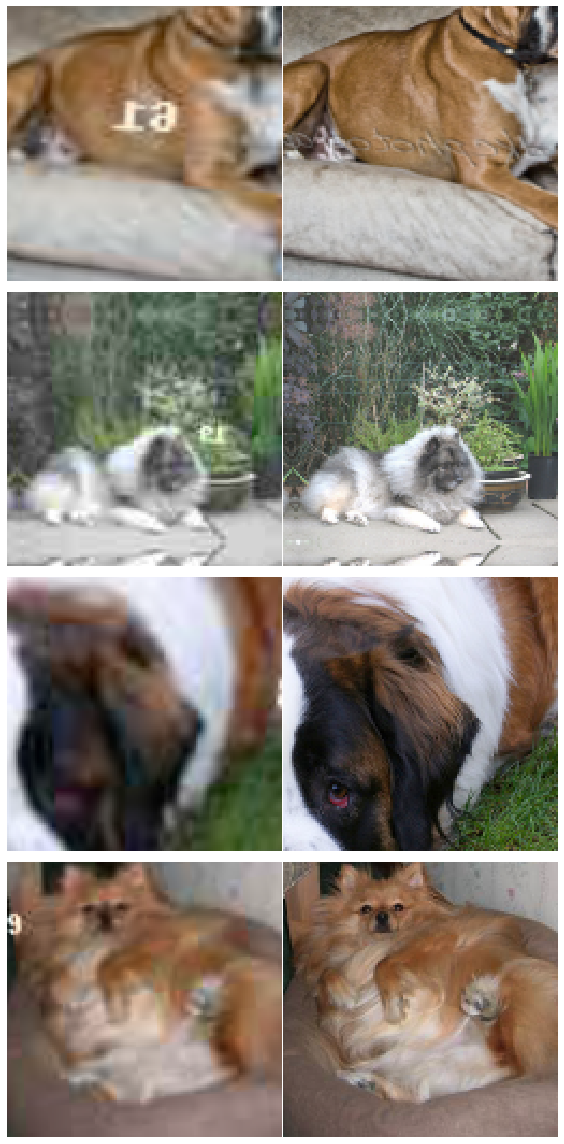

In [12]:
data_gen = get_data(bs,size)
data_gen.show_batch(4)

In [13]:
wd=1e-3

In [14]:
y_range=(-3.,3.)

In [15]:
loss_gen = MSELossFlat()

In [16]:
def create_gen_learner():
    return unet_learner(data_gen,arch,wd=wd,blur=True,norm_type=NormType.Weight,self_attention=True,y_range=y_range,loss_func=loss_gen)

In [17]:
learn_gen=create_gen_learner()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


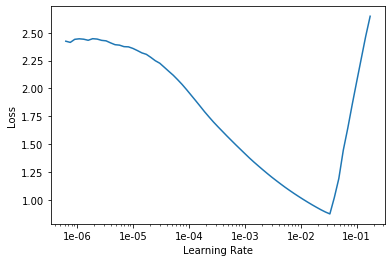

In [18]:
lr_find(learn_gen)
learn_gen.recorder.plot()

In [20]:
learn_gen.fit_one_cycle(2,max_lr=0.5e-3,pct_start=0.8)

In [21]:
learn_gen.unfreeze()

In [23]:
learn_gen.fit_one_cycle(3,slice(1e-6,1e-3))

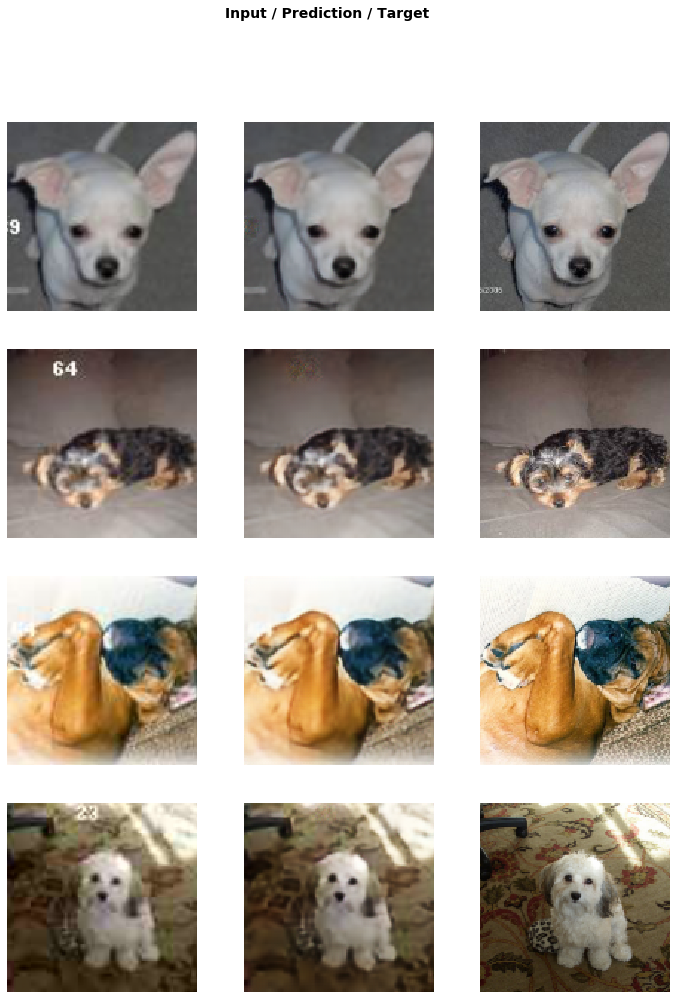

In [24]:
learn_gen.show_results(4,4)

In [25]:
learn_gen.save('gen-pre2')

## Save generated images

In [26]:
learn_gen.load('gen-pre2');

In [27]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [28]:
path_gen.mkdir(exist_ok=True)

In [29]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl: #ach batch of the data loader
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [30]:
save_preds(data_gen.fix_dl)

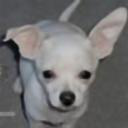

In [32]:
PIL.Image.open(path_gen.ls()[0])

## Train critic

In [34]:
learn_gen=None
gc.collect()

5766

In [35]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [36]:
data_critic=get_crit_data([name_gen,'images'],bs=bs,size=size)

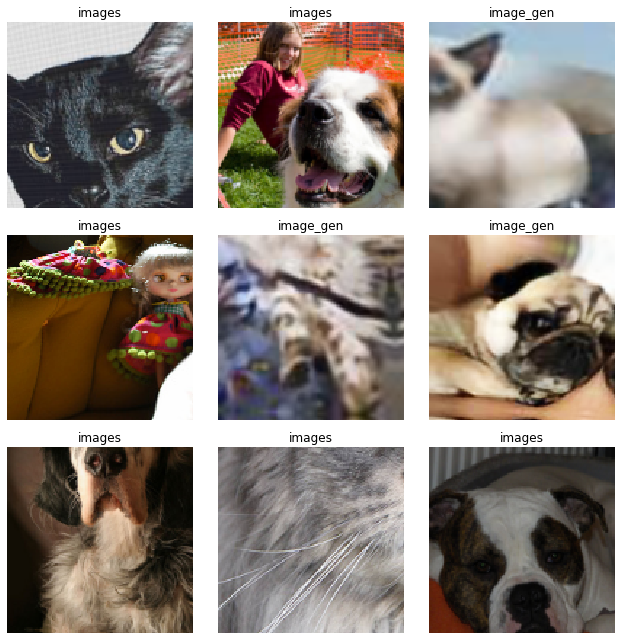

In [37]:
data_critic.show_batch(rows=3,ds_type=DatasetType.Train,imgsize=3)

In [38]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [39]:
def create_critic_learner(data,metrics):
    return Learner(data,gan_critic(),metrics=metrics,loss_func=loss_critic,wd=wd)

In [40]:
learn_critic = create_critic_learner(data_critic,accuracy_thresh_expand)

In [41]:
learn_critic.fit_one_cycle(6,1e-3)

In [42]:
learn_critic.save('critic-pre2')

## GAN

In [43]:
learn_crit=None
learn_gen=None
gc.collect()

24353

In [44]:
data_crit = get_crit_data(['crappy','images'],bs=bs,size=size)

In [45]:
learn_crit = create_critic_learner(data_crit,metrics=None).load('critic-pre2')

In [47]:
learn_gen = create_gen_learner().load('gen-pre2')

To define a GAN Learner, we just have to specify the learner objects foor the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by learn_crit.loss_func. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0).

The loss of the generator is weighted sum (weights in weights_gen) of learn_crit.loss_func on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the learn_gen.loss_func applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [48]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [49]:
lr = 1e-4

In [50]:
learn.fit(40,lr)

In [51]:
learn.save('gan-1c')

In [52]:
learn.data=get_data(16,192)

In [53]:
learn.fit(10,lr/2)

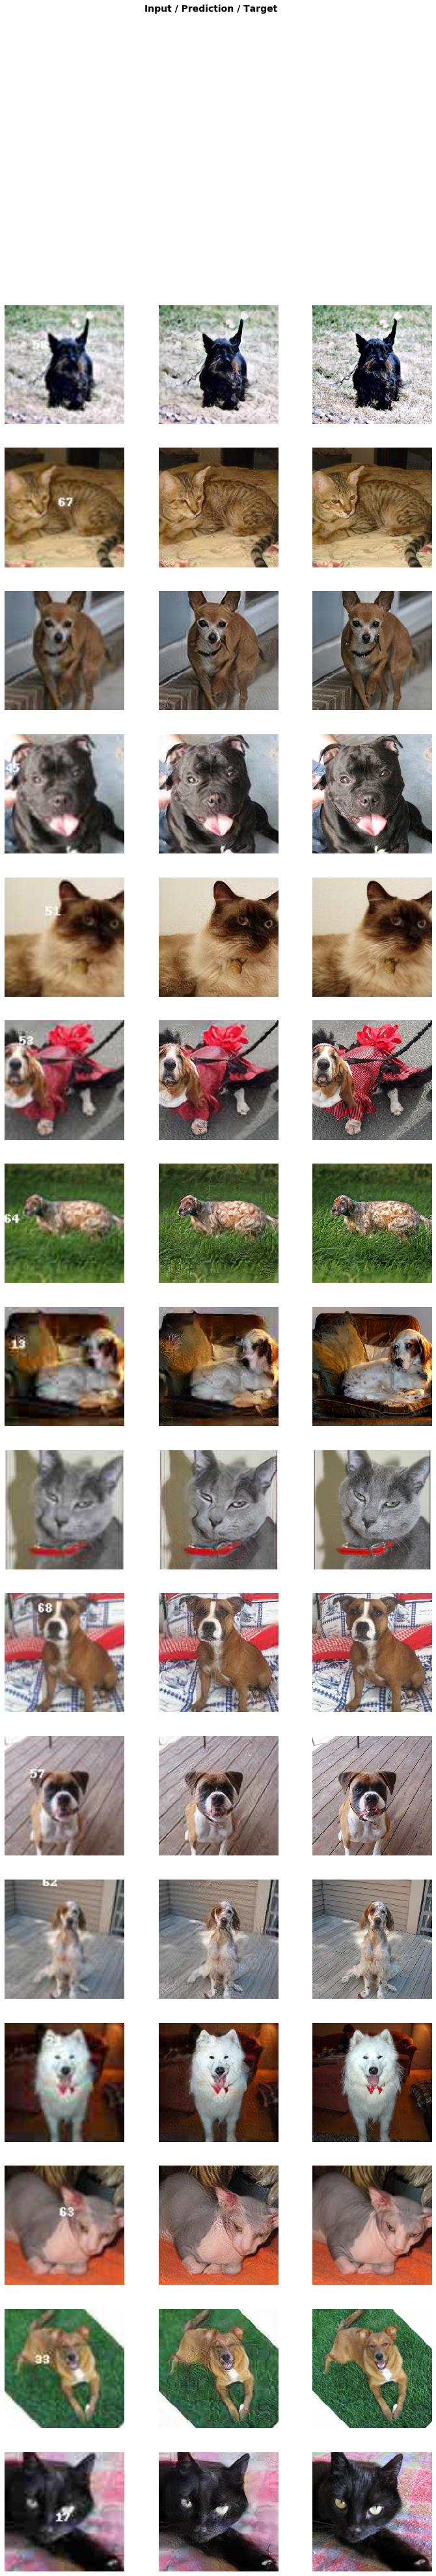

In [54]:
learn.show_results(rows=16)

In [57]:
learn.save('gan-1c')